In [1]:
import random
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences
from keras.utils import plot_model

In [3]:
!pip freeze > requirements.txt

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [4]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test.csv.zip
./data/train.csv
./data/test.csv
./data/train.csv.zip


In [5]:
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

# SETUP
В setup выносим основные настройки

In [6]:
# MODEL
BATCH_SIZE  = 128
EPOCH       = 10
VAL_SPLIT   = 0.15 

# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 150

DATA_PATH = './data/'

# Data
#### TRAIN

In [7]:
train_df = pd.read_csv(DATA_PATH+'train.csv',)

In [8]:
train_df.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    54214 non-null  object
 1   genre   54214 non-null  object
 2   text    54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


Text(0, 0.5, 'Counts')

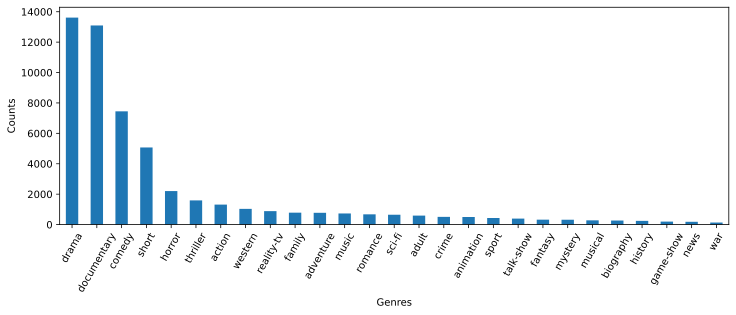

In [10]:
train_df.genre.value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)

In [11]:
len(train_df.genre.value_counts())

27

#### TEST

In [12]:
test_df = pd.read_csv(DATA_PATH+'test.csv')
test_df.head()

,name,text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    54200 non-null  object
 1   text    54200 non-null  object
dtypes: object(2)
memory usage: 847.0+ KB


### Target

In [14]:
Y = pd.get_dummies(train_df.genre)
CLASS_NUM = Y.shape[1]
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (54214, 27)


In [15]:
Y.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing

### Clean Data

In [16]:
# данные у нас и так достаточно чистые

### Tokenize data and convert the text to sequences

Токенизация — это самый первый шаг при обработке текста. Заключается в разбиении (разделении) длинных строк текста в более мелкие: абзацы делим на предложения, предложения на слова. В итоге мы получаем некий словарь, который позволит превратить наш текст в векторное представление для сети.

в Keras есть замечательная утилита [Tokenizer](https://keras.io/preprocessing/text/) которая позволяет сделать всю предобработку буквально в пару строчек кода! 
Больше примеров в коде можно найти тут:  
https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

In [17]:
# для построения словаря мы используем весь текст, и TRAIN, и TEST
all_text = train_df.text.append(test_df.text, ignore_index=True)

/tmp/ipykernel_19342/384103739.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_text = train_df.text.append(test_df.text, ignore_index=True)


In [18]:
print(type(all_text))
print(len(all_text))

<class 'pandas.core.series.Series'>
108414


In [19]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(all_text)

CPU times: user 4.45 s, sys: 17.8 ms, total: 4.47 s
Wall time: 4.47 s


теперь переведем наш текст в вектор

In [20]:
%%time
sequences = tokenize.texts_to_sequences(train_df.text)
sequences_matrix = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(sequences_matrix.shape)

(54214, 150)
CPU times: user 1.7 s, sys: 19.9 ms, total: 1.72 s
Wall time: 1.72 s


In [21]:
# вот так теперь выглядит наш текст
print(train_df.text[1])
print(sequences_matrix[1])

 A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     3   194
     2   255     9     3   162 13276   201    41     3   906  4142   201
    11  1493

# Model
Нужно поэкспериментировать с гиперпараметрами сети и составом слоев.

In [22]:
def RNN():
    inputs = Input(name='inputs', shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(MAX_WORDS, 50, input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(100)(layer)
    layer = Dense(256, activation='relu', name='FC1')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(CLASS_NUM, activation='sigmoid', name='out_layer')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [23]:
model = RNN()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           1000000   
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 FC1 (Dense)                 (None, 256)               25856     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 27)                6939      
                                                                 
Total params: 1,093,195
Trainable params: 1,093,195
Non-train

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

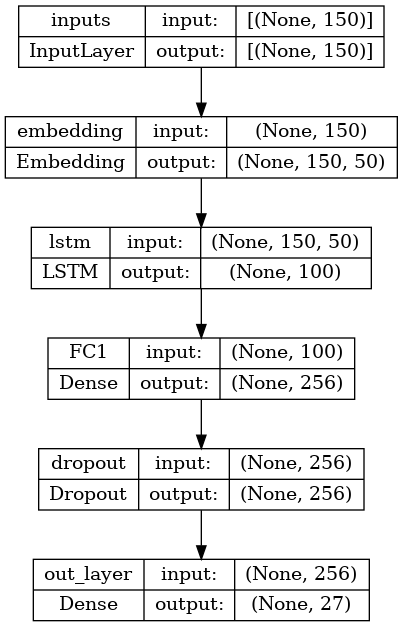

In [25]:
plot_model(model, to_file='ltsm_model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
history = model.fit(sequences_matrix,Y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCH,
                    validation_split=VAL_SPLIT)

Epoch 1/10
361/361 [==============================] - 6s 8ms/step - loss: 2.2142 - accuracy: 0.3328 - val_loss: 1.8866 - val_accuracy: 0.4510
Epoch 2/10
361/361 [==============================] - 3s 7ms/step - loss: 1.7544 - accuracy: 0.4757 - val_loss: 1.8466 - val_accuracy: 0.4492
Epoch 3/10
361/361 [==============================] - 3s 7ms/step - loss: 1.5722 - accuracy: 0.5333 - val_loss: 1.7854 - val_accuracy: 0.5006
Epoch 4/10
361/361 [==============================] - 3s 7ms/step - loss: 1.3755 - accuracy: 0.5960 - val_loss: 1.8094 - val_accuracy: 0.5148
Epoch 5/10
361/361 [==============================] - 3s 7ms/step - loss: 1.2125 - accuracy: 0.6432 - val_loss: 1.8040 - val_accuracy: 0.5178
Epoch 6/10
361/361 [==============================] - 3s 7ms/step - loss: 1.0413 - accuracy: 0.6910 - val_loss: 1.9389 - val_accuracy: 0.5040
Epoch 7/10
361/361 [==============================] - 3s 7ms/step - loss: 0.8968 - accuracy: 0.7334 - val_loss: 2.1893 - val_accuracy: 0.5081
Epoch 

In [27]:
model.save('ltsm_keras_nlp.h5')

In [31]:
print(history.history)

{'loss': [2.214249610900879, 1.7543542385101318, 1.5721982717514038, 1.37552011013031, 1.212477445602417, 1.0412583351135254, 0.8967569470405579, 0.7675593495368958, 0.6901748776435852, 0.5775583386421204], 'accuracy': [0.332783579826355, 0.4756624102592468, 0.5333000421524048, 0.5960373878479004, 0.6431934833526611, 0.6910006403923035, 0.733382523059845, 0.7684078216552734, 0.7900002002716064, 0.8259152173995972], 'val_loss': [1.88658607006073, 1.8465659618377686, 1.7853922843933105, 1.809391975402832, 1.80398690700531, 1.9389307498931885, 2.189310312271118, 2.3931431770324707, 2.5476229190826416, 2.823544979095459], 'val_accuracy': [0.4510020911693573, 0.4491577446460724, 0.50055330991745, 0.514816164970398, 0.5177671313285828, 0.5039960741996765, 0.5080536007881165, 0.5026435256004333, 0.48874953389167786, 0.4728882312774658]}


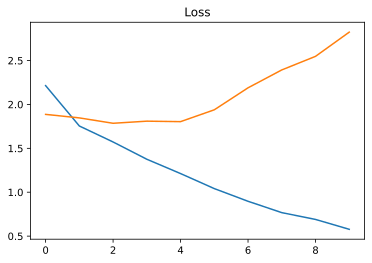

In [28]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.show();

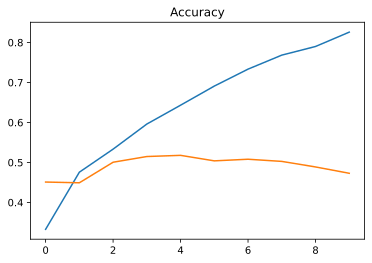

In [32]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.show();

# Submission

In [34]:
test_sequences = tokenize.texts_to_sequences(test_df.text)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [35]:
%%time
predict_proba = model.predict(test_sequences_matrix)

1694/1694 [==============================] - 3s 2ms/step
CPU times: user 3.91 s, sys: 85 ms, total: 4 s
Wall time: 3.44 s


In [36]:
# сохраняем predict_proba, чтоб потом можно было построить ансамбль решений
predict_proba = pd.DataFrame(predict_proba, columns=Y.columns)
predict_proba.to_csv('ltsm_predict_proba.csv', index=False)
predict_proba.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0.072280,3.196052e-04,0.088223,0.007035,0.031181,0.329630,0.145529,0.706729,0.996531,0.261054,...,3.165646e-05,0.004739,0.245117,0.012868,0.942534,0.000030,0.000075,4.336381e-01,0.054823,5.085202e-04
1,0.106627,1.178074e-04,0.030045,0.000133,0.013720,0.960471,0.061385,0.963260,0.999921,0.400706,...,6.212291e-06,0.004286,0.799694,0.000046,0.843604,0.000007,0.000007,1.737238e-01,0.009639,1.339678e-03
2,0.000087,4.978171e-11,0.019540,0.000029,0.848683,0.004237,0.000002,0.999994,0.704543,0.073795,...,2.269009e-01,0.437776,0.000001,0.000245,0.961363,0.001562,0.045595,5.818315e-07,0.003367,3.421506e-09
3,0.070111,6.947445e-05,0.018878,0.000153,0.005467,0.956446,0.081757,0.919952,0.999947,0.299062,...,6.471311e-07,0.001473,0.755803,0.000074,0.942466,0.000001,0.000002,4.111696e-01,0.003750,4.074092e-04
4,0.175754,7.938688e-02,0.117207,0.045847,0.186983,0.719810,0.310462,0.344768,0.946912,0.644392,...,2.064724e-03,0.050305,0.914841,0.010980,0.766987,0.003317,0.003899,3.268874e-01,0.087896,1.904961e-02


In [37]:
predict_genre = Y.columns[np.argmax(predict_proba.values, axis=1)]

In [38]:
submission = pd.DataFrame({'id':range(1, len(predict_genre)+1), 
                           'genre':predict_genre}, 
                          columns=['id', 'genre'])

submission.to_csv('ltsm_submission.csv', index=False)
submission.head()

,id,genre
0,1,drama
1,2,drama
2,3,documentary
3,4,drama
4,5,drama


## Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Поиграться с архитектурой
* Подобрать другие переменные (MAX_WORDS, MAX_SEQUENCE_LENGTH, батч и тп)
* Добавить политику обучения
* Добавить в обучение название фильма (для pro: попробуйте это сделать через concatenate слой)
* Попробовать уже предобученные Векторизаторы (GLOVE, W2V и тд)
* Попробовать уже предобученные модели (BERT, TRANFORMER и тд)
* Построить ансамбль из разных архитектур